## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

In [1]:
#Import libralies

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

%matplotlib inline
np.random.seed(42)

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
len(df.query('group == "treatment" & landing_page == "old_page"')) + len(df.query('group == "control" & landing_page == "new_page"'))

3893

f. Check any of the rows have missing values.

In [7]:
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. I should remove that row in order to examine date accurately.

a. Create a new dataset that meets the specifications.  Store your new dataframe in **df2**.

In [9]:
df2 = df.query('group == "control" & landing_page == "old_page" or group == "treatment" & landing_page == "new_page"')

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [11]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


a. How many unique **user_id**s are in **df2**?

In [12]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
sum(df2['user_id'].duplicated())

1

c. What is the row information for the repeat **user_id**? 

In [14]:
print(df2[df2['user_id'].duplicated()])

      user_id                   timestamp      group landing_page  converted
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
df2.drop_duplicates(subset='user_id', keep="first", inplace=True)

C:\Users\bebop\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
df['converted'].mean()

0.11965919355605512

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
df2.query('group == "control"').converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
df2.query('group == "treatment"').converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
len(df2.query('landing_page == "new_page"')) / len(df2['landing_page'])

0.5000619442226688

e. Consider my results from a. through d. above, and explain below whether I think there is sufficient evidence to say that the new treatment page leads to more conversions.

**The probability of conversion for the Treatment group is 0.1189, The Control group is 0.1203.There is no sufficient exidence to say that new treatment group page leads more conversions at this point.**

<a id='ab_test'></a>
### Part II - A/B Test

Because of the time stamp associated with each event, I could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do I stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do I run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider I need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of **5%**, what should my null and alternative hypotheses be?  

$$H_{0} : p_{new} \leq p_{old} $$ 
$$H_{1} : p_{new} > p_{old} $$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [20]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [21]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [22]:
n_new = len(df2.query('landing_page == "new_page"'))
n_new

145310

d. What is $n_{old}$?

In [23]:
n_old = len(df2.query('landing_page == "old_page"'))
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
np.random.seed(42)
new_page_converted = np.random.choice([0,1] , size = n_new , p = [p_new , 1-p_new])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
np.random.seed(42)
old_page_converted = np.random.choice([0,1] , size = n_old , p = [p_old , 1-p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
obs_diff = new_page_converted.mean() - old_page_converted.mean()
obs_diff

9.034776111582765e-06

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [31]:
p_diffs = np.array(p_diffs)
p_diffs.mean()

-1.9209034432763517e-05

In [87]:
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation
p_diffs.mean()

-8.907999825411504e-06

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

In [56]:
p_diffs = np.array(p_diffs)

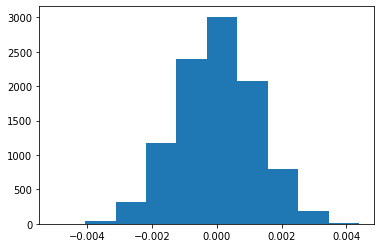

In [57]:
plt.hist(p_diffs);

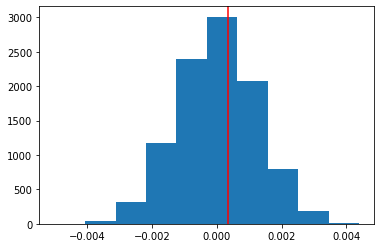

In [58]:
plt.hist(p_diffs);
plt.axvline(x = obs_diff , color = 'red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [88]:
p_value = (p_diffs > obs_diff).mean()
p_value

0.3764

k. **In part J, I computed p_value.It shows the probablilty when null_hypothesis is True,what percentage of extreme results come up. P_values less than 0.05 are considered the defference is statistically significant. The p_value I calculated is greater than 0.05. I can say it is not stastistically significant.** 
### It fail to reject the null hypothesis (I reject the new page).

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [89]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [90]:
import statsmodels.api as sm

convert_old = len(df2.query('landing_page == "old_page" & converted == "1"'))
convert_new = len(df2.query('landing_page == "new_page" & converted == "1"'))
n_old = len(df2.query('landing_page == "old_page"'))
n_new = len(df2.query('landing_page == "new_page"'))

In [91]:
print(convert_old)
print(convert_new)
print(n_old)
print(n_new)

17489
17264
145274
145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [92]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The computed z-score is -1.31, and negative z-score reveals the alternative score is below the mean average. And the computed p_value is 0.905, greater than 0.05 again, that means it is not statistically  significant. There is no evidence to reject the null, both z-score and p-values I found agree with the finding in parts J and K.**

<a id='regression'></a>
### Part III - A regression approach

In this final part, I will see that the result I acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**I should use Logistic Regression models in this case. Since there are two outcomes(conversion or no-conversion), the responce will be non-quantitative responce but categorical responce and if there are only two possible outcomes,Logistic regression models would match in this dataset.** 

b. The goal is to use **statsmodels** to fit the regression model I specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, I first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [ ]:
df2.head()

In [ ]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df['group'])['treatment']

In [ ]:
df2.head()

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [ ]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = logit_mod.fit()
results.summary()

In [ ]:
np.exp(-0.0150)

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

**Conversions are 0.985 times as likely on new_pages than old_pages holding all else constant.**

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

**p-value is 0.19. It is different because:**

**In the part2, I use this hypothesis to see the mean conversion of new page is higher or not(Quantitive).
$$H_{0} : p_{new} \leq p_{old} $$ 
$$H_{1} : p_{new} > p_{old} $$**


**And for the regression model, I use this hupothesis to see new pages converts or not(Categorical).**
**$$H_{0} : p_{new} = p_{old} $$ 
$$H_{1} : p_{new} \neq p_{old} $$**

f. Now, I am considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into my regression model.  Are there any disadvantages to adding additional terms into my regression model?

**The reason why it is good to consider other factors is because I will be seeing higher probability of observing significant difference. Each individual have different mindset to reach conversions, it is better for us to examine conversion from multiple view.**

**There are several disadvantages,
a: A linear relationships might not exist between responce and explanatory variables.
b: I mught have correlated errors.
c: I might not have constant variance of my errors.
d: There might be outliers that hurt my model.
e:significant bivariate relationships are not always significant in multiple regression model(Multicollinearity), and they results misleading results.**

**In order to fix these problems, I need to computing Variance Inflation Factors(VIFs) for each variables. If you see VIFs higher than 10,I would remove those variables.**
 
**It is important to check how I am going to use the data model, such as
a; To see how X and y variables are related
b: To predict the best responce variable
c: To find which variables are useful in predicting the responce
and choose which variable I may need to use carefully.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. I will need to read in the **countries.csv** dataset and merge together my datasets on the approporiate rows. 

In [ ]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

In [ ]:
### Create the necessary dummy variables
countries_df['country'].unique()

In [ ]:
df_new[['CA', 'UK' , 'US']] = pd.get_dummies(df_new['country'])
df_new = df_new.drop(['CA'], axis = 1)
df_new.head()

h. Though I have now looked at the individual factors of country and page on conversion, I would now like to look at an interaction between page and country to see if there significant effects on conversion.  

Provide the summary results, and your conclusions based on the results.

In [ ]:
### Fit Your Linear Model And Obtain the Results
logit_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'US' , 'UK']])
results = logit_mod.fit()
results.summary()

In [ ]:
 np.exp(0.0408) , np.exp(0.0507)

In [ ]:
#Compute VIFs and drop columns if the score is higher than 10
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
y,X = dmatrices('converted ~  US + UK', df_new, return_type = 'dataframe')

In [ ]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X. values,i) for i in range(X.shape[1])]
vif['features'] = X.columns
vif

In [ ]:
#VIFs are less than 10. I will not drom columns.

**☆RESULT**

**US: Compared to CA user, for every one user increase, conversions are 1.04 times as likely**

**UK: Compared to CA user, for every one user increase, conversions are 1.05 times as likely**

In [ ]:
#Influences associated with time
df_new['timestamp'] = pd.to_datetime(df_new['timestamp'])

In [ ]:
df_new['date'] = df_new['timestamp'].dt.date

In [ ]:
df_new['date'] = pd.to_datetime(df_new['date'])

In [ ]:
df_new['weekday'] = pd.to_datetime(df_new['date']).dt.dayofweek

In [ ]:
df_new["weekday"] = (df_new["weekday"] < 5).astype(int)

In [ ]:
df_new.head()

In [ ]:
### Fit Linear Model And Obtain the Results
logit_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'weekday']])
results = logit_mod.fit()
results.summary()

In [ ]:
np.exp(0.0006)

**☆RESULT**

**On weekdays, the chance of conversions are 1.0006 times more likely than on weekends holding all variables constant.**

<a id='conclusions'></a>
## Conclusions

①After cleaning the data, I computed the probability of conversion for the Treatment group is 0.1189, The Control group is 0.1203.I found there is no sufficient exidence to say that new treatment group page leads more conversions.

②I set a hypothesys test to see that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%.
$$H_{0} : p_{new} \leq p_{old} $$ 
$$H_{1} : p_{new} > p_{old} $$
I performed the sampling distribution for the difference in converted between the two pages over 10,000 iterations of calculating an estimate from the null.I computed p_value.It shows the probablilty when null_hypothesis is True,what percentage of extreme results come up. P_values less than 0.05 are considered the defference is statistically significant. The p_value I calculated was greater than 0.05. I can say it is not stastistically significant. It fail to reject the null hypothesis (I reject the new page).
I also computed z-score, that was -1.31, and negative z-score reveals the alternative score was below the mean average. And I computed p_value in a different method, that was 0.905, greater than 0.05 again, that means not statistically  significant. There is no evidence to reject the null.

③I used Logistic Regression models since there are two outcomes(conversion or no-conversion).I found conversions are 0.985 times as likely on new_pages than old_pages holding all else constant.And p-value was 0.19. It is different because I used a different(Categorical) hupothesis to see new pages converts or not:
**$$H_{0} : p_{new} = p_{old} $$ 
$$H_{1} : p_{new} \neq p_{old} $$**
But still, p-value was higher than 0.05(Fail to reject the null).

I added country columns by joining different dataset to see effects based on which country a user lives.The result was:
US: Compared to CA user, for every one user increase, conversions are 1.04 times as likely
UK: Compared to CA user, for every one user increase, conversions are 1.05 times as likely
I checked VIFs to prevent Multicollinearities and I did not drop any columns because VIF scores were all less than 10.

Lastly I added the influences associated with time on conversion.I created a column of "weekdays" to see if there is any conversion difference associated with time.By fitting a linear model, I obtained the result: On weekdays, the chance of conversions are 1.0006 times more likely than on weekends holding all variables constant.

As a result of ①～③, there is no sufficient exidence to say that new treatment group page leads more conversions(Fail to reject the null).And there is no effect based on which country a user lives, or time they access in order to ger higher conversions.